In [1]:
import pandas as pd 
import numpy as np 
import torch.nn as nn
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashaiavadhani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
/Users/aashaiavadhani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aashaiavadhani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aashaiavadhani/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version 

In [2]:
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import time
import re
from tqdm import tqdm
from tqdm import tqdm_notebook
import pandas as pd

In [3]:
response = requests.get("https://newspunch.com/category/news/us/")
soup = BeautifulSoup(response.text, 'html.parser')


In [4]:

link = soup.find_all('a')




In [4]:
#within each of the articles, need to find the url link
def getLinksURLFromPage(link):
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('article')
    links = []
    for article in articles:
        links.append(article.find('a').get('href'))
    return links


"""
Input: Link main URL page (str)
Output: Number of pages for the website (int)
"""
def getNumPages(head_page_link):
    #have to find a with a class "page-numbers"
    root = requests.get(head_page_link)
    soup_text_page = BeautifulSoup(root.text, 'html.parser')
    string_page_numbers = soup_text_page.find_all("a", class_ = "page-numbers")
    links = []
    for soup_item in string_page_numbers:
        link = soup_item.get("href")
        links.append(link)

    page_numbers = []
    
    for link in tqdm(links):
        numbers = re.findall(r'[0-9]+', link)
        if(len(numbers) == 0): continue
        else:
            numPagesList = re.findall(r'[0-9]+', link)
            num_pages = numPagesList[0]
            page_numbers.append(int(num_pages))
        
    max_pages = max(page_numbers)

    return max_pages
    
    
    

In [5]:
# links = getLinksURL("https://newspunch.com/category/news/us/")
max_pages = getNumPages("https://newspunch.com/category/news/us")

base_url = "https://newspunch.com/category/news/us"

def get_all_articles_from_domain(base_url, num_pages):
    
    all_urls = []
    for page_num in tqdm(range(1,num_pages+1)):
        all_urls.append(base_url + "/page/" +str(page_num))
        
    content = []
    for url in tqdm(all_urls):
      list_links_page = getLinksURLFromPage(url)
      for link in list_links_page:
        content.append(get_content(link))
    return content
        
    
"""
Input: Url for an article (str)
Output: Content of the article (dictionary)
Output: Dictionary (keys: title, content, author) correspond to values(title of article , content of article , author of article) (TYPE: strs)
"""
def get_content(url_article):
    
    result_content = dict()

    
    
    request_text = requests.get(url_article).text
    content = BeautifulSoup(request_text, "html.parser")
    
    #get the title of the article
    title_article = content.find("h1", class_ = "entry-title")
    if(title_article != None): 
        result_content["title"] = title_article.get_text()
    else:
        result_content["title"] = np.nan
    
    #getting the author of the article
    author = content.find("a", class_ = "fn")
    if(author != None): 
        result_content["author"] = author.get_text()
    else:
        result_content["author"] = np.nan
        
    #getting the date of the article
    date = content.find("span", class_ = "entry-meta-date updated")
    if(date != None):
        date_result = date.find("a")
        if(date_result != None): date_result = date_result.get_text()
        result_content["date"] = date_result
    
    #get the comments
    comments = content.find("span", class_ = "entry-meta-comments")
    if(comments != None):
        comment = comments.find("a")
        num_comments = 0
        if(comment != None): num_comments = comment.get_text()
        result_content["num_comments"] = num_comments
    
    
    #get the content of the article 
    text_data = content.find('div', class_='entry-content clearfix')
    if(text_data != None):
        #find all the paragarphs with the text
        paragraphs = text_data.find_all("p")
        text = ""
        if(paragraphs != None):
            for body_data in paragraphs:
                if(body_data != None):  text += body_data.get_text()
        result_content["content"] = text
        
    
    #get the snippet of the article 
    
    snippet = content.find("div", class_ = "entry-content clearfix")
    if(snippet != None):
        text = snippet.find("p")
        num_comments = 0
        if(text != None): 
            data = text.find("strong")
            result = ""
            if(data != None): 
                result = data.get_text()
            result_content["snippet"] = result
    return result_content

100%|██████████| 3/3 [00:00<00:00, 11672.46it/s]


In [9]:
url = "https://newspunch.com/category/news/us"
numPages = getNumPages(url)
article_content = get_all_articles_from_domain(url, 500)


100%|██████████| 500/500 [1:05:37<00:00,  7.87s/it]


In [7]:
print(len(article_content))

100


In [30]:
#creates a csv file from the article data
def save_data(article):
           
    titles = []
    author = []
    content = []
    snippet = []
    num_comments = []
    date = []
    label = []
    
      
    for i in tqdm(range(len(article))):
        dictionary = article[i]
        if(type(dictionary["snippet"]) != str):
            continue
            
        titles.append(dictionary["title"])
        author.append(dictionary["author"])
        content.append(dictionary["content"])
        snippet.append(dictionary["snippet"])
        date.append(dictionary["date"])
        num_comments.append(dictionary["num_comments"])
        label.append(0)
    df = pd.DataFrame({'title': titles, 'content': content, 'date': date, 'snippet': snippet, 'author': author, "number of comments": num_comments, "label": label})
    df.to_csv('FAKE_news_punch_data.csv')
    

save_data(article_content)

NameError: name 'article_content' is not defined

## FAKE NEWS REDDIT
Used this website: https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

In [5]:
import pandas as pd
import requests
import json
import csv
import time
import datetime
from psaw import PushshiftAPI


In [6]:

def gatherDataOnion():
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit="theonion", filter=['title', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=10000))
    result_dictionary = dict()
    title = []
    author = []
    subscribers = []
    date = []
    score = []
    domain_source = []
    
    for submission in tqdm(scrape_list,position = 0):

        original_source = submission[2]
        domain_source.append(original_source)
        
        
        title_submission = submission[5]
        title.append(title_submission)
        
        author_submission = submission[0]
        author.append(author_submission)
        
        
        
        subscriber_submission = submission[4]
        subscribers.append(subscriber_submission)
                
        date_created = submission[1]
        date.append(date_created)
        
        
        score_submission = submission[3]
        score.append(score_submission)
        
        
    label = [0] * len(title)
    df = pd.DataFrame({'title': title, 'author': author, 'date': date, 'score': score, 'subscribers':subscribers,'source':domain_source, 'label': label })
    df.to_csv('better_fake_onion.csv')




In [32]:

def gatherDataReal():
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit="nottheonion", filter=['title', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=20000))
    print(scrape_list[0])
    result_dictionary = dict()
    title = []
    author = []
    subscribers = []
    date = []
    score = []
    domain_source = []
    
    for submission in tqdm(scrape_list,position = 0):

        original_source = submission[2]
        domain_source.append(original_source)
        
        
        title_submission = submission[5]
        title.append(title_submission)
        
        author_submission = submission[0]
        author.append(author_submission)
        
        
        
        subscriber_submission = submission[4]
        subscribers.append(subscriber_submission)
                
        date_created = submission[1]
        date.append(date_created)
        
        
        score_submission = submission[3]
        score.append(score_submission)
        
    label = [1] * len(title)
    
    df = pd.DataFrame({'title': title, 'author': author, 'date': date, 'score': score, 'subscribers':subscribers,'source':domain_source, 'label': label })
    df.dropna()
    df.to_csv('real_onion_good.csv')




In [22]:
gatherDataOnion()

100%|██████████| 10000/10000 [00:00<00:00, 910064.22it/s]


In [33]:
gatherDataReal()

100%|██████████| 20000/20000 [00:00<00:00, 901584.00it/s]

submission(author='Bittah_Genius__c', created_utc=1575559272, domain='ktbs.com', score=1, subreddit_subscribers=16038190, title="Pinterest and The Knot take a stand against 'plantation weddings'", created=1575577272.0, d_={'author': 'Bittah_Genius__c', 'created_utc': 1575559272, 'domain': 'ktbs.com', 'score': 1, 'subreddit_subscribers': 16038190, 'title': "Pinterest and The Knot take a stand against 'plantation weddings'", 'created': 1575577272.0})


In [3]:
import datetime

In [22]:
dataframe_onion = pd.read_csv('better_fake_onion.csv')
dataframe_onion['timestamp'] = pd.to_datetime(dataframe_onion['date'], unit='s')

dataframe_onion_real = pd.read_csv('real_onion_good.csv')
dataframe_onion_real['timestamp'] = pd.to_datetime(dataframe_onion_real['date'], unit='s')

In [23]:
print("TheOnion start date:", dataframe_onion['timestamp'].min())
print("TheOnion end date:", dataframe_onion['timestamp'].max())

TheOnion start date: 2017-09-02 13:35:05
TheOnion end date: 2019-12-05 02:09:38


In [24]:
print("TheOnion start date:", dataframe_onion_real['timestamp'].min())
print("TheOnion end date:", dataframe_onion_real['timestamp'].max())

TheOnion start date: 2019-08-20 12:48:00
TheOnion end date: 2019-12-05 14:55:52


In [18]:
from textblob import TextBlob
import matplotlib.dates as mdates


In [11]:
#X axis

time = list(dataframe_onion['timestamp'])


In [12]:
#Y AXIS (sent analysis)
title_list = dataframe_onion["title"]
sentimentAxis = []
for i in tqdm(range(len(dataframe_onion["title"])), position = 0):
    text = title_list[i]
    analysis = TextBlob(text)
    sentiment = analysis.sentiment
    sentimentAxis.append(sentiment)

100%|██████████| 10000/10000 [00:02<00:00, 4266.68it/s]


In [27]:
np.histogram([1, 2, 1], bins=[0, 1, 2, 3])

(array([0, 2, 1]), array([0, 1, 2, 3]))

100%|██████████| 20000/20000 [00:04<00:00, 4232.31it/s]


Text(0.5, 1.0, 'Real News Sentiment Analysis Over Time')

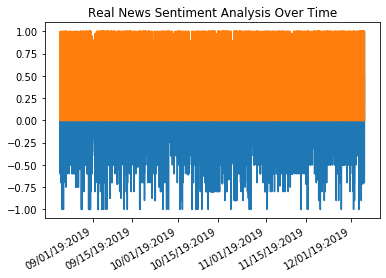

In [30]:
#REAL NEWS DATASET
time_real = list(dataframe_onion_real['timestamp'])
title_list = dataframe_onion_real["title"]
sentimentAxisReal = []
for i in tqdm(range(len(dataframe_onion_real["title"])), position = 0):
    text = title_list[i]
    analysis = TextBlob(text)
    sentiment = analysis.sentiment
    sentimentAxisReal.append(sentiment)
    
plt.plot(time_real,sentimentAxisReal)
# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%D:%Y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Real News Sentiment Analysis Over Time')


Text(0.5, 1.0, 'Fake News Sentiment Analysis Over Time')

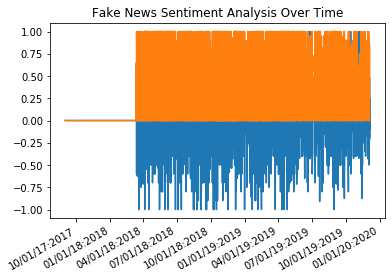

In [31]:
plt.plot(time,sentimentAxis)

# beautify the x-labels
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%D:%Y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Fake News Sentiment Analysis Over Time')


In [ ]:
#FOR CLEANING THE DATA 

In [5]:
fake_news_data = pd.read_csv('FAKE_news_punch_data.csv')
fake_news_data.dropna(inplace = True)
print(len(fake_news_data))



4933


In [21]:
"""
Input: Takes in a list of the content data
Output: Cleans the text data
"""

#DROP ROWS WITH NANS 

def clean_data(orig_data):
    
    new_content = []
    stringPunctuation = string.punctuation
    punctuation = re.compile("[" + stringPunctuation + "]")
    stop_word = set(stopwords.words('english')) 
    
    for article in tqdm(orig_data,position = 0):
        
                                 
        #in order to effectively use regular expressions for punctuation, we can translate the string punctuation into a regular expressions compilation

        #replace apostrophies with empty string
        apostrophy = re.compile("[']")
        if(type(article) != str):
            print(article)
            print(type(article))
        article = apostrophy.sub("",article)

        #replaces the rest of the punctuations that strip did not get with spaces
        article = punctuation.sub(" ",article)    



        #remove punctuation
        stripped_punc = article.strip(stringPunctuation)
        #replaces the rest of the punctuations that strip did not get with spaces
        article =  punctuation.sub(" ",article)
        article = article.lower()
        new_article = []
        #tokenize words
        tokenized = nltk.tokenize.word_tokenize(article)
        new_article = []
        #remove stopwords and extra punctuation
        for word in tokenized:
            if((word not in stop_word) and (word not in stripped_punc)):
                new_article.append(word)

        new_content.append(new_article)
    return new_content

In [22]:
new_content = clean_data(fake_news_data["content"])
new_snippet = clean_data(fake_news_data["snippet"])
new_title = clean_data(fake_news_data["title"])

100%|██████████| 4933/4933 [00:00<00:00, 10434.12it/s]


In [12]:
#all strings
temp_list = []
for content in (fake_news_data["content"]):
    temp_list.append(content)
print(len(temp_list))
new_string = " ".join(temp_list)
for word in new_string:
    print(word)
#if(word not in stop_word and word not in stripped_punc):
#    print(word)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
labels = [0] * len(fake_news_data)
fake_news_data["label"] = labels
fake_news_data["content"] = new_string


In [28]:
final_article = ""
for article in tqdm(fake_news_data["content"],position = 0):
    temp = "".join(article)
    print(type(temp))
    print(temp)
    final_article += "".join(article)
    break

print(final_article[0:100])

  0%|          | 0/4933 [00:00<?, ?it/s]

<class 'str'>
['clintons', 'jeffrey', 'epstein', 'new', 'mexico', 'dna', 'bill', 'hillary', 'chelsea', 'white', 'daily', 'mail', 'bill', 'clintons', 'epstein', 'clinton', 'epstein', 'seen', 'dailymailtv', 'wild', 'west', 'american', 'epstein', 'lolita', 'express', 'jared', 'kellogg', 'brice', 'gordon', '–daily', 'mailzerohedge', 'clintons', 'epstein', 'lolita', 'express', 'boeing', 'epstein', 'july', 'kellogg', 'brice', 'gordon', 'clintons', 'epstein', 'brice', 'kellogg', 'brice', 'clintons', 'bill', 'bill', 'western', 'mail', 'kellogg', 'westworld', 'yeah', 'clintons', 'epstein', 'jared', 'kelloggas', 'mail', 'epstein', 'bill', 'clinton', 'upper', 'east', 'monica', 'lewinsky', 'drudge', 'kellogg', 'epstein', 'new', 'mexico', 'november', 'mail', 'epstein', 'kellogg', 'due', 'considering', 'epstein', 'kellogg', 'gordon', 'instead', '–daily', 'mail', 'epstein', 'brice', 'maybe', 'bryce']
['clintons', 'jeffrey', 'epstein', 'new', 'mexico', 'dna', 'bill', 'hillary', 'chelsea', 'white', 'd


In [28]:
fake_news_data.content = new_content
fake_news_data.snippet = new_snippet
fake_news_data.title = new_title



In [41]:
labels = [0] * len(fake_news_data)
fake_news_data["label"] = labels
print(len(fake_news_data))

4933


In [37]:
fake_news_data.to_csv('finally.csv')


KeyboardInterrupt: 